# Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from math import sqrt

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
x_train = pd.read_csv('../x_train.csv', index_col='ID')
y_train = pd.read_csv('../y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('../x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


In [3]:
ret=[f'RET_{k}' for k in range(20,0,-1)]
vol=[f'VOLUME_{k}' for k in range(20,0,-1)]

# Exploration des secteurs

Nombre de points par secteur :

In [4]:
nb_sto = max(len(train.STOCK.unique()),len(test.STOCK.unique()))
nb_sub_ind = max(len(train.SUB_INDUSTRY.unique()),len(test.SUB_INDUSTRY.unique()))
nb_ind = max(len(train.INDUSTRY.unique()),len(test.INDUSTRY.unique()))
nb_grp_ind = max(len(train.INDUSTRY_GROUP.unique()),len(test.INDUSTRY_GROUP.unique()))
nb_sec = max(len(train.SECTOR.unique()),len(test.SECTOR.unique()))
print("Nombre total d'actions :", nb_sto)
print("Nombre total de sub-industries :", nb_sub_ind)
print("Nombre total d'industries :", nb_ind)
print("Nombre total de groupes industriels :", nb_grp_ind)
print("Nombre total de secteurs :", nb_sec)
print(max(test.SUB_INDUSTRY.unique()))
print(max(test.INDUSTRY.unique()))
print(max(test.INDUSTRY_GROUP.unique()))
print(max(test.SECTOR.unique()))


Nombre total d'actions : 5350
Nombre total de sub-industries : 182
Nombre total d'industries : 75
Nombre total de groupes industriels : 27
Nombre total de secteurs : 12
182
74
26
11


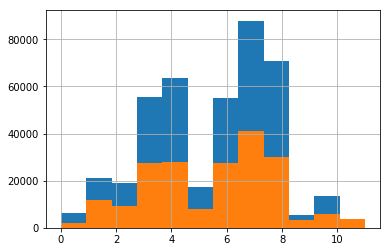

In [5]:
x_train.SECTOR.hist(bins=nb_sec)
test.SECTOR.hist(bins=nb_sec)

In [6]:
train.groupby(by='SECTOR').count()['DATE']
#test.groupby(by='STOCK').count()['DATE']

SECTOR
0      6304
1     21264
2     18967
3     55473
4     63519
5     17295
6     55123
7     87903
8     70843
9      5555
10    13295
11     3054
Name: DATE, dtype: int64

# Définition des fonctions d'arborescence

In [7]:
arbre = ['SECTOR','INDUSTRY_GROUP','INDUSTRY','SUB_INDUSTRY','STOCK'];

def niv_arbre(df, lvl_arb, chemin, nb_min_per_mod):
    
    if (lvl_arb == 4 and df.shape[0]>nb_min_per_mod):
            return([[4,df.shape[0],chemin,chemin]])
    
    elif (df.shape[0]<nb_min_per_mod):
        
        if (lvl_arb == 0):
            return([lvl_arb, df.shape[0], chemin, chemin])
        
        return([lvl_arb, df.shape[0], chemin, chemin[0:len(chemin)-1]])
   
    else :
        res = []
   
        for sub_step in (df[arbre[lvl_arb+1]].unique()):
            sub_df = df[df[arbre[lvl_arb+1]]==sub_step]
            
            if sub_df.shape[0]>nb_min_per_mod:
                res = res + niv_arbre(sub_df,lvl_arb+1, chemin+[sub_step],nb_min_per_mod)
                
            elif (lvl_arb == -1):
                res = res + [[0,sub_df.shape[0],chemin+[sub_step],chemin+[sub_step]]]
                
            else : 
                res = res + [[lvl_arb,sub_df.shape[0],chemin+[sub_step],chemin]]
       
        return(res)

def creer_niv_arbre(df, nb_min_per_mod):
    
    grp_data = niv_arbre(df, -1, [], nb_min_per_mod) 
    
    for i in range(12):
        grp_data.append([0,0,0,[i]])
        
    models = np.unique(np.asarray(grp_data)[:,3])
    
    new_model = []
    for i in range(5,-1,-1):  
        for model in models:
            div = len(model)-1
            if i == div:
                new_model.append([div,model[div]])
    models = new_model
    
    
    return(grp_data,models)

# Cross validation

In [8]:
# Paramètres :
nb_feat = 20 #nb de jours pris en compte
nb_shifts = 5 #nombre de features supplémentaires
seuil_arbo = 36000 #Seuil d'arborescence

# Nettoyage des données :
train_cl = train.copy()
test_cl = test.copy()
for indu in range(nb_ind):
    for ret_t,vol_t in zip(ret,vol):
        med_ret_train = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
        med_vol_train = train[vol_t][train['INDUSTRY_GROUP']==indu].median()
        med_ret_test = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
        med_vol_test = train[vol_t][train['INDUSTRY_GROUP']==indu].median()

        train_cl[ret_t] = train_cl[ret_t].fillna(med_ret_train)
        train_cl[vol_t] = train_cl[vol_t].fillna(med_vol_train)
        test_cl[ret_t] = test_cl[ret_t].fillna(med_ret_test)
        test_cl[vol_t] = test_cl[vol_t].fillna(med_vol_test)
seuil_ret = 1000;
seuil_vol = 1000;
train_cl  = train_cl [np.all([train_cl[col]<seuil_ret for col in ret],axis=0)]
train_cl  = train_cl [np.all([train_cl[col]<seuil_vol for col in vol],axis=0)]

# Mise à l'échelle :
scaler = StandardScaler()
train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])

# Création de l'arborescence :
grp_data, loc_mods = creer_niv_arbre(train_cl,seuil_arbo)
print('Nous allons creer', len(loc_mods), 'modèles afin de couvrir les', len(grp_data), 'groupes de données détectés.')

# Sélection des features :
features_base = ret[-nb_feat:]+vol[-nb_feat:]
target = 'RET'

shifts = range(1,nb_shifts+1)
new_features = []
statistics = ['median']
target_feature = 'RET'
for shift in range(1,nb_shifts+1):
    print(shift)
    for stat in statistics:
        feat = f'{target_feature}_{shift}'
        name = f'{target_feature}_{shift}_SUBDIVISION_{stat}'
        new_features.append(name)

        train_new = pd.Series()
        test_new = pd.Series()

        grille_train = pd.Series(index=train_cl.index)
        grille_test = pd.Series(index=test_cl.index)


        for n in range(len(loc_mods)):    

            grp = loc_mods[n]
            niv = grp[0]

            if niv == 5:
                gb_features = ['STOCK', 'DATE']
            else:
                gb_features = [arbre[niv], 'DATE']

            train_set_sub = train_cl[train_cl[arbre[niv]]==grp[1]]
            test_set_sub = test_cl[test_cl[arbre[niv]]==grp[1]]

            train_set_sub = train_set_sub[grille_train.isna()]
            test_set_sub = test_set_sub[grille_test.isna()]

            train_index = train_set_sub.index
            test_index = test_set_sub.index

            grille_train[train_index] = 1
            grille_test[test_index] = 1

            train_new_sub = pd.Series(train_set_sub.groupby(gb_features)[feat].transform(stat),index=train_index)
            test_new_sub = pd.Series(test_set_sub.groupby(gb_features)[feat].transform(stat),index=test_index)

            train_new = pd.concat([train_new,train_new_sub])
            test_new = pd.concat([test_new,test_new_sub])

        train_cl[name] = train_new
        test_cl[name] = test_new

features = features_base + new_features

# Entraînement des modèles
models = []
arbre_minuscule = ["du secteur","du groupe industriel","de l'industrie","de la sous-industrie","de l'action"]
print(len(loc_mods), 'modèles à créer')
for n in range(len(loc_mods)):
    loc_mod = loc_mods[n]
    niv = loc_mod[0]
    sub = loc_mod[1]

    x_train_cl = train_cl[features][train_cl[arbre[niv]]==sub]
    y_train_cl = train_cl[target][train_cl[arbre[niv]]==sub]
    print("Modèle", n,": calculé sur les données",arbre_minuscule[niv],sub,".",x_train_cl.shape[0],"données.")

    rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
    }

    model = RandomForestClassifier(**rf_params)
    model.fit(x_train_cl, y_train_cl)
    models.append([model,[niv,sub]])

# Prédiction
y_pred = pd.Series()
y_test= pd.Series(index=test_cl.index)


nb_ligne = 0;
for n in range(len(models)):
    model = models[n][0]

    print("Groupe : ", n)

    div = arbre[models[n][1][0]]  
    sub = models[n][1][1] 

    x_test = test_cl[test_cl[div]==sub].loc[:,features]
    x_test = x_test[y_test.isna()]

    if (x_test.shape[0] > 0):

        index = x_test.index
        y_test[index]=1

        y_new = pd.Series(model.predict(x_test),index=index)
        y_pred = pd.concat([y_pred,y_new])

y_pred = y_pred.sort_index()

Nous allons creer 13 modèles afin de couvrir les 37 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match Da

13 modèles à créer
Modèle 0 : calculé sur les données du groupe industriel 16 . 39290 données.
Modèle 1 : calculé sur les données du secteur 0 . 6304 données.
Modèle 2 : calculé sur les données du secteur 1 . 21264 données.
Modèle 3 : calculé sur les données du secteur 2 . 18967 données.
Modèle 4 : calculé sur les données du secteur 3 . 55473 données.
Modèle 5 : calculé sur les données du secteur 4 . 63519 données.
Modèle 6 : calculé sur les données du secteur 5 . 17295 données.
Modèle 7 : calculé sur les données du secteur 6 . 55122 données.
Modèle 8 : calculé sur les données du secteur 7 . 87903 données.
Modèle 9 : calculé sur les données du secteur 8 . 70843 données.
Modèle 10 : calculé sur les données du secteur 9 . 5555 données.
Modèle 11 : calculé sur les données du secteur 10 . 13295 données.
Modèle 12 : calculé sur les données du secteur 11 . 3054 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  12


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [9]:
y_pred.name = target
# y_pred.to_csv('./sub1114F.csv', index=True, header=True)